<a href="https://colab.research.google.com/github/renata-cruz/GSoC/blob/main/GSoC2022_Disimpy_WM_Substrates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INCF GSoC 2022 1.1. Implementation of White Matter Substrates in Disimpy

###Google Summer of Code

###Renata Cruz

In [ ]:
import numpy as np
import numba
import scipy.stats
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import norm
!pip install disimpy
from disimpy import gradients, simulations, substrates, utils

## 2D Implementation: Place Circles in a Square with Periodic Boundaries

Create the circles:
- Draw N numbers from a gamma distribution with given parameters. These will be the radii for the circles;
- Sort the numbers from largest to smallest;
- For each radii, draw a random position within a square (simulated voxel);

To implement periodic conditions:
- When drawing a new circle, also create mirrored circles in the eight neighbouring positions;
- Select all the circles with the center positioned inside the square or that intersect with the boundaries.

To finalize:
- Check if the circle or any of the mirrors overlap with any other placed circles/mirrors;
- Repeat position sampling until there is no overlap.

In [2]:
def _sampled_radii(shape, scale, n_objects):
  """Sample radii from a gamma distribution.

  Parameters
  ----------
  shape : float
      Shape of the gamma distribution.
  scale : float
      Scale of the gamma distribution.
  n_objects: int
      Size of the sample.

  Returns
  -------
  sampled_radii : numpy.ndarray
      Array with the sampled radii in decrescent order.
  """
  sampled_radii = np.random.gamma(shape, scale, n_objects)
  sampled_radii = np.sort(sampled_radii)[::-1]
  return np.array(sampled_radii)


def _mirrored_circles(C, r, voxel_size):
    """Create mirrored versions of a circle in the eight surrounding voxels.
    This will add a periodic boundary condition to the central voxel.

    Parameters
    ----------
    C : tuple
        Center of circle C(x, y).
    r : float
        Radius of the circle.
    voxel_size : float
        Size of the voxel.

    Returns
    -------
    mirrors : numpy.ndarray
        Array with center coordinates for the mirrors and their radii.
    """
    x, y = C
    mirrors = np.array(
        [
            [x, y, r],
            [x - voxel_size, y, r],
            [x + voxel_size, y, r],
            [x, y - voxel_size, r],
            [x, y + voxel_size, r],
            [x - voxel_size, y - voxel_size, r],
            [x + voxel_size, y - voxel_size, r],
            [x - voxel_size, y + voxel_size, r],
            [x + voxel_size, y + voxel_size, r],
        ]
    )
    return mirrors


@numba.jit
def _overlapping_mirrors(mirrors, placed_mirrors):
  """Check if any circle in a mirror position overlaps with other circles.

  Parameters
  ----------
  mirrors : numpy.ndarray
    Array with center coordinates for the mirrors positions of a circle and their radii.
  placed_mirrors : numpy.ndarray
    Stored center coordinates for the mirrors positions of a circle and their radii.
  
  Returns
  -------
  boolean
  """
  x = mirrors[:,:2]
  y = placed_mirrors[:,:2]
  d = cdist(x,y)
  r_m = np.unique(mirrors[:,2])
  r_pm = placed_mirrors[:,2]
  overlap = 0
  for col, r in zip(range(len(placed_mirrors)), r_pm):
    if np.any(d[:,col] < (r + r_m)):
      overlap += 1
  if overlap == 0:
    return False
  return True


def _boundaries(lower_b, higher_b):
  """Define the 2D boundaries of the voxel.
  
  Parameters
  ----------
  lower_b : float
    Lower limit of the boundary.
  higher_b : float
    Higher limit of the boundary.
  
  Returns
  -------
  boundaries : numpy.ndarray
    Array with 2D boundaries of the voxel.
  """
  top = [(lower_b, higher_b), (higher_b, higher_b)]
  bottom = [(lower_b, lower_b), (higher_b, lower_b)]
  left = [(lower_b, lower_b), (lower_b, higher_b)]
  right = [(higher_b, lower_b), (higher_b, higher_b)]
  boundaries = [bottom, left, top, right]
  return np.asarray(boundaries)


def _dist_lineseg_point(p, a, b):
  """Distance between a point P(x,y) and a line segment AB.

  Parameters
  ----------
  p : numpy.ndarray
      Array with the catesian coordinates of point P.
  a : numpy.ndarray
      Array with the catesian coordinates of point A.
  b : numpy.ndarray
      Array with the catesian coordinates of point B.

  Returns
  -------
  distance : numpy.ndarray
      Distance between between point P(x,y) and line segment AB.
  """
  p = np.atleast_2d(p)
  d = np.divide(b - a, np.linalg.norm(b - a))
  s = np.dot(a - p, d)
  t = np.dot(p - b, d)
  h = np.maximum.reduce([s, t, np.zeros(len(p))])
  c = np.cross(p - a, d)
  distance = np.hypot(h, c)
  return distance


def _periodic_boundaries(mirrors, voxel_size):
  """Selection of circles contained inside the voxel and interating with the boundaries.

  Parameters
  ----------
  mirrors : numpy.ndarray
    Array with the catesian coordinates of point P.
  voxel_size : float
    Size of the voxel.

  Returns
  -------
  periodic_circles : numpy.ndarray
    Array with the periodically bounded circles.
  """
  boundaries = _boundaries(0, voxel_size)
  circles = []
  for mirror in mirrors:
    x, y, r = mirror
    if (0 <= x <= voxel_size and 0 <= y <= voxel_size):
        circles.append(mirror)
    for b in boundaries:
      p1, p2 = b
      p1 = np.asarray(p1)
      p2 = np.asarray(p2)
      d = _dist_lineseg_point((x,y), p1, p2)
      if d < r :
        circles.append(mirror)
  periodic_circles = np.unique(circles, axis=0)
  return np.asarray(periodic_circles)


@numba.jit
def _place_circles(shape, scale, n_objects, voxel_size, max_iterations=1e2):
  """Pack circles in a voxel with periodic boundaries.

  Parameters
  ----------
  n_objects : int
    Number of circles to be sampled.
  shape : float
    Shape of the gamma distribution to sample the radii.
  scale : float
    Scale of the gamma distribution to sample the radii.
  voxel_size : float
      Size of the voxel.
  max_iterations : float
      Maximum number of iterations to place a circle in the voxel. Default is equal to 1e2.

  Returns
  -------
  circles : numpy.ndarray
      Array with the center coordinates and radii of the cirlces placed in the voxel.
  placed_mirrors : numpy.ndarray
      Array with the center coordinates and radii of the cirlces placed in the voxel and their mirrored versions in the surrounding voxels.
  """
  radii = _sampled_radii(shape, scale, n_objects)
  placed_mirrors = np.zeros((n_objects * 9, 3))
  filled_positions = 1
  for r in radii:
    placed = False
    i = 0
    while not placed and i < max_iterations:
        i += 1
        x, y = np.random.random(2) * voxel_size
        mirrors = _mirrored_circles((x, y), r, voxel_size)
        if np.all(placed_mirrors == 0):
            for mirror, k in zip(mirrors, range(len(mirrors))):
                placed_mirrors[k] = mirror
            placed = True
        else:
            intersects = False
            if _overlapping_mirrors(mirrors, placed_mirrors):
              intersects = True
              break
            if not intersects:
              interval = filled_positions * 9
              for mirror, k in zip(mirrors, range(interval, len(mirrors) + interval)):
                  placed_mirrors[k] = mirror
              placed = True
              filled_positions += 1
  circles = _periodic_boundaries(placed_mirrors, voxel_size = 1e-4)
  return circles, placed_mirrors

In [ ]:
circles, mirrors = _place_circles(shape = 3, scale = 1e-6, n_objects = int(5e2), voxel_size = 1e-4, max_iterations=1e4)

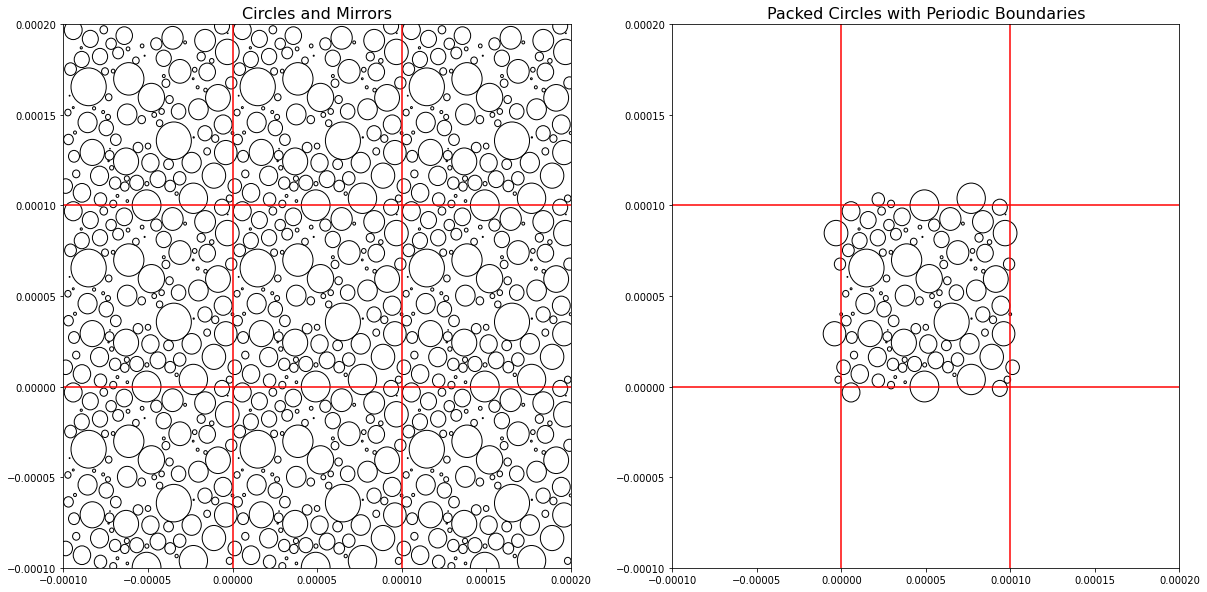

In [4]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
for mirror in mirrors:
  mirror = plt.Circle((mirror[0], mirror[1]), mirror[2], fill=False)
  ax1.add_artist(mirror)
ax1.set_xlim([-1e-4, 2e-4])
ax1.set_ylim([-1e-4, 2e-4])
ax1.axvline(0, color='r')
ax1.axhline(0, color='r')
ax1.axvline(1e-4, color='r')
ax1.axhline(1e-4, color='r')
ax1.set_title('Circles and Mirrors', size=16)

ax2 = fig.add_subplot(122)
for circle in circles:
  circle = plt.Circle((circle[0], circle[1]), circle[2], fill=False)
  ax2.add_artist(circle)
ax2.set_xlim([-1e-4, 2e-4])
ax2.set_ylim([-1e-4, 2e-4])
ax2.axvline(0, color='r')
ax2.axhline(0, color='r')
ax2.axvline(1e-4, color='r')
ax2.axhline(1e-4, color='r')
ax2.set_title('Packed Circles with Periodic Boundaries', size=16)
plt.show()

In these plots, the centered square requesents the main '2D voxel' while the surrounding neighboring squares are where the mirrored circles are positioned. In the end, only circles within or intersecting the square in the center remain.

## 3D Implementation: Create Cylindric Substrates with Triangular Meshes

In this section we need to include both complete circles and circles that intersect with the boundaries (partial circles).

- Find the interection points with the boundaries for the partial circles;
- Compute the thetas for each circle to find the vertices of the triangles;
- Compute the vertices with the thetas and connect them creating the faces and triangles. Include the z-coordinate to create a 3D mesh - **cylinder**.

In [5]:
def _intersection_points(C, r, voxel_size):
  """Compute the intersection points between a circle and the boundaries in a voxel.

  Parameters
  ----------
  C : tuple
      Center of circle C(x, y).
  r: float
      Radius of the circle. 
  voxel_size: float
      Size of the voxel.

  Returns
  -------
  intersection_points : numpy.array
      Array with the coordinates for the points of intersection - p1(x1,y1), p2(x2,y2).
  """
  x, y = C
  boundaries = _boundaries(0, voxel_size)
  points = []
  intersection_points = []
  for b in boundaries:
    p1, p2 = b
    p1 = np.asarray(p1)
    p2 = np.asarray(p2)
    d = _dist_lineseg_point((x,y), p1, p2)
    if d < r:
      if p1[1] == p2[1]:
        i1 = x - np.sqrt(r ** 2 - (p1[1] - y) ** 2), p1[1]
        i2 = x + np.sqrt(r ** 2 - (p1[1] - y) ** 2), p1[1]
      else:
        i1 = p1[0], y - np.sqrt(r ** 2 - (p1[0] - x) ** 2)
        i2 = p1[0], y + np.sqrt(r ** 2 - (p1[0] - x) ** 2)
      points.append(i1)
      points.append(i2)
  for point in points:
    xx, yy = point
    if (0 <= xx <= voxel_size and 0 <= yy <= voxel_size):
      intersection_points.append(point)
  return intersection_points


def _thetas(C, r, voxel_size, n_faces):
  """Compute the theta angles for the partial and complete cylinders.

  Parameters
  ----------
  C : tuple
      Center of circle C(x, y).
  r : float
      Radius of the circle. 
  voxel_size : float
      Size of the voxel.
  n_faces : int
      Number of faces for the triangular mesh.

  Returns
  -------
  thetas : numpy.array
      Array with the theta angles for each segment in a circle.
  """
  intersection_points = _intersection_points(C, r, voxel_size)
  if not len(intersection_points) == 0:
    p1, p2 = intersection_points
    ang1 = np.arctan2(p1[1]-C[1], p1[0]-C[0])
    ang2 = np.arctan2(p2[1]-C[1], p2[0]-C[0])
    angs = [ang1, ang2]
    xx, yy = C
    min_ang = min(angs)
    max_ang = max
    if not (0 <= xx <= voxel_size and 0 <= yy <= voxel_size):
      thetas = np.linspace(min(angs), max(angs), n_faces+1)
    else:
      thetas = np.linspace(max(angs), 2 * np.pi + min(angs), n_faces+1)
  else:
    thetas = np.linspace(0, 2*np.pi, n_faces+1)
  return thetas


def _cylinder_mesh(C, r, voxel_size, n_faces, h):
  """Generate a cylindric mesh.
  
  Parameters
  ----------
  C: tuple
      Center of circle C(x, y).
  r: float
      Radius of the circle. 
  voxel_size: float
      Size of the voxel.
  n_faces: int
      Number of faces for the triangular mesh.
  h: int
      Hight of the cylinder.

  Returns
  -------
  vertices: numpy.ndarray
      Array of vertices for the triangular mesh.
  faces: numpy.ndarray
      Array of faces for the triangular mesh.
  """
  vertices = []
  faces = []
  thetas = _thetas(C, r, voxel_size, n_faces)
  for theta in thetas:
    v_base = [r * np.cos(theta) + C[0], r * np.sin(theta) + C[1], 0]
    v_h = [r * np.cos(theta) + C[0], r * np.sin(theta) + C[1], h]
    vertices.append(v_base)
    vertices.append(v_h)
  indexes = range(len(vertices)-2)
  for i in indexes:
    t = [i, i+1, i+2]
    faces.append(t)
  return np.array(vertices), np.array(faces)

### Testing: Intersection Points

Text(0.5, 1.0, 'Intersection Points')

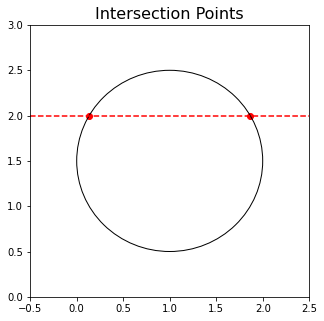

In [6]:
C = (1, 1.5)
r = 1
voxel_size = 2

i_points = _intersection_points(C, r, voxel_size)
i_points = np.asarray(i_points)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()

circle = plt.Circle((C[0], C[1]), r, fill=False)
ax.add_artist(circle)
ax.scatter(i_points[:, 0], i_points[:, 1], c='r')
ax.axhline(2, color='r', linestyle = '--')
ax.set_xlim([-0.5, 2.5])
ax.set_ylim([0, 3])

ax.set_title('Intersection Points', size=16)


### Testing: Thetas

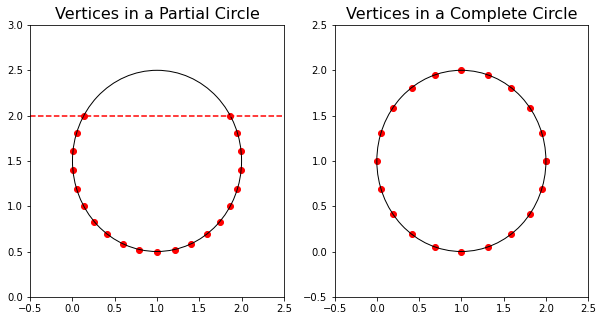

In [8]:
Cp = (1, 1.5)
Cc = (1, 1)
r = 1
voxel_size = 2
n_faces = 20

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)

vertices_p = []
thetas_p = _thetas(Cp, r, voxel_size, n_faces)
for theta in thetas_p:
  v = [r * np.cos(theta) + Cp[0], r * np.sin(theta) + Cp[1], 0]
  vertices_p.append(v)
vertices_p = np.asarray(vertices_p)

p_circle = plt.Circle((Cp[0], Cp[1]), r, fill=False)
ax1.add_artist(p_circle)

ax1.scatter(vertices_p[:, 0], vertices_p[:,1], color='r')
ax1.axhline(2, color='r', linestyle = '--')
ax1.set_xlim([-0.5, 2.5])
ax1.set_ylim([0, 3])

ax1.set_title('Vertices in a Partial Circle', size=16)



ax2 = fig.add_subplot(122)

vertices_c = []
thetas_c = _thetas(Cc, r, voxel_size, n_faces)
for theta in thetas_c:
  v = [r * np.cos(theta) + Cc[0], r * np.sin(theta) + Cc[1], 0]
  vertices_c.append(v)
vertices_c = np.asarray(vertices_c)

c_circle = plt.Circle((Cc[0], Cc[1]), r, fill=False)
ax2.add_artist(c_circle)

ax2.scatter(vertices_c[:, 0], vertices_c[:,1], color='r')
ax2.set_xlim([-0.5, 2.5])
ax2.set_ylim([-0.5, 2.5])


ax2.set_title('Vertices in a Complete Circle', size=16)

plt.show()

### Testing: Cylindric 3D Mesh

In [9]:
vertices_partial, faces_partial = _cylinder_mesh((1.5, 1), 1, 2, 10, 3)
vertices_complete, faces_complete = _cylinder_mesh((1, 1), 0.5, 2, 10, 3)

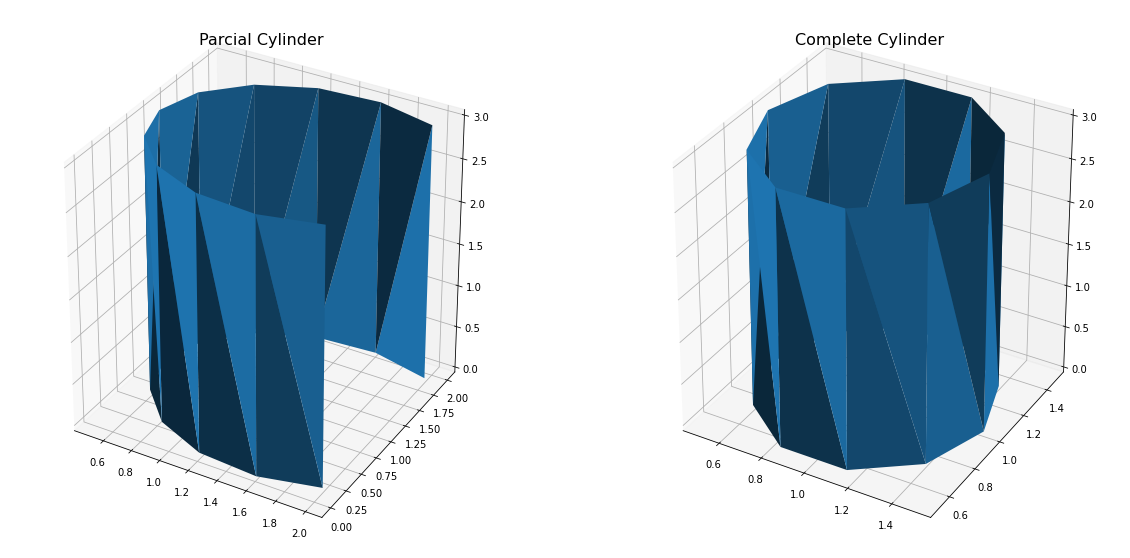

In [11]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(
    vertices_partial[:, 0],
    vertices_partial[:, 1],
    vertices_partial[:, 2],
    triangles=faces_partial,
  )
ax1.set_title('Parcial Cylinder', size=16)

ax2 = fig.add_subplot(122, projection='3d')

ax2.plot_trisurf(
    vertices_complete[:, 0],
    vertices_complete[:, 1],
    vertices_complete[:, 2],
    triangles=faces_complete,
  )
ax2.set_title('Complete Cylinder', size=16)
plt.show()

## Packed Cylinders and Intgration with Disimpy

Combine the previous sections and create a packed voxel of cylindric 3D meshes. Test the result with the *substrate.mesh()* function from the Disimpy module.

In [12]:
def packed_cylinders(shape, scale, n_objects, voxel_size, n_faces, h):
  """Create a voxel of packed cylindric meshes with gamma distributed radii.
  
  Parameters
  ----------
  shape: float
      The shape of the gamma distribution.
  scale: float
      The scale of the gamma distribution.
  n_objects: int
      Number of cylinders to be sampled.
  voxel_size: float
      Size of the voxel.
  n_faces: int
      Number of faces for the triangular mesh.
  h: int
      Hight of the cylinders.

  Returns
  -------
  vertices: numpy.ndarray
      Array of vertices for the triangular mesh.
  faces: numpy.ndarray
      Array of faces for the triangular mesh.
  """
  circles = _place_circles(shape, scale, n_objects, voxel_size)[0]
  vertices = np.empty((0,3), int)
  faces = np.empty((0,3), int)
  for base, i in zip(circles, range(len(circles))):
    x, y, r = base[0], base[1], base[2]
    v, f = _cylinder_mesh((x,y), r, voxel_size, n_faces, h)
    f = f + (len(v)*i)
    vertices = np.append(vertices, v, axis=0)
    faces = np.append(faces, f, axis=0)
  return np.asarray(vertices), np.asarray(faces)

In [ ]:
vertices, faces = packed_cylinders(shape = 3, scale = 1e-6, n_objects = int(5e2), voxel_size = 1e-4, n_faces = 50, h = 10e-6)

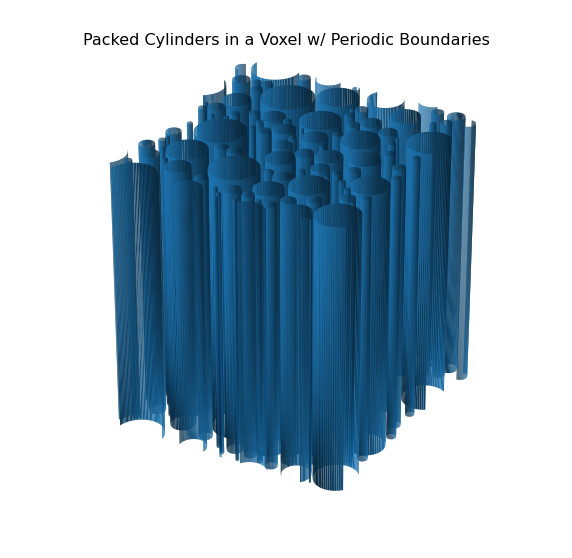

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(
    vertices[:, 0],
    vertices[:, 1],
    vertices[:, 2],
    triangles=faces,
  )
ax.set_title('Packed Cylinders in a Voxel w/ Periodic Boundaries', size=16)
plt.axis("off")
fig.show()

Aligning the corner of the simulated voxel with the origin
Moved the vertices by [2.62317206e-06 8.47032947e-22 0.00000000e+00]
Dividing the mesh into subvoxels
Finished dividing the mesh into subvoxels


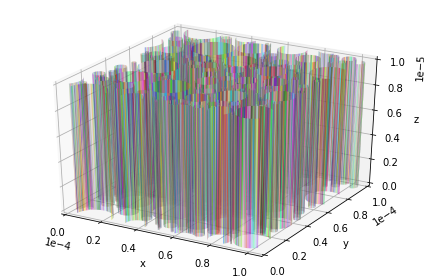

In [15]:
substrate = substrates.mesh(vertices, faces, True)
utils.show_mesh(substrate)

As we can see in these final plots, we implemented the periodic boundaries to the voxel yet the orientation of some intersecting cylinders is not correct.